# Blob Flow

Analysis of blob flow through validators, builders, and relays on Ethereum mainnet.

In [1]:
import pandas as pd
import plotly.graph_objects as go

from lib import (
    get_client_optional,
    load_or_query,
    show_fig,
    DEFAULT_NETWORK,
)

# =============================================================================
# PARAMETERS
# =============================================================================
NETWORK = DEFAULT_NETWORK
MIN_BLOCKS = 10  # Minimum blocks for entity filtering
FORCE_QUERY = False  # Set to True to refresh cached data

# =============================================================================
# SETUP
# =============================================================================
client = get_client_optional()

In [2]:
# Query blob inclusion data (proposers and builders)
sql_proposer_blobs = f"""
WITH blocks AS (
    SELECT
        slot,
        slot_start_date_time,
        proposer_index,
        block_root,
        meta_network_name
    FROM canonical_beacon_block
    WHERE
        meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
    GROUP BY slot, slot_start_date_time, proposer_index, block_root, meta_network_name
),
blobs AS (
    SELECT
        slot,
        block_root,
        count(DISTINCT blob_index) AS blob_count
    FROM canonical_beacon_blob_sidecar
    WHERE
        meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
    GROUP BY slot, block_root
),
mev AS (
    SELECT
        slot,
        any(builder_pubkey) AS builder_pubkey,
        any(relay_name) AS relay_name
    FROM mev_relay_proposer_payload_delivered
    WHERE
        meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
    GROUP BY slot
)
SELECT
    b.slot,
    b.slot_start_date_time,
    b.proposer_index,
    e.entity AS proposer_entity,
    coalesce(bl.blob_count, 0) AS blob_count,
    m.builder_pubkey AS winning_builder_pubkey,
    m.relay_name AS winning_relay
FROM blocks b
GLOBAL LEFT JOIN ethseer_validator_entity e
    ON b.proposer_index = e.index
    AND b.meta_network_name = e.meta_network_name
LEFT JOIN blobs bl
    ON b.slot = bl.slot AND b.block_root = bl.block_root
LEFT JOIN mev m
    ON b.slot = m.slot
ORDER BY b.slot DESC
"""

df_proposer_blobs = load_or_query(client, sql_proposer_blobs, "proposer_blobs", FORCE_QUERY)

# Fill missing values
df_proposer_blobs["proposer_entity"] = df_proposer_blobs["proposer_entity"].fillna("Unknown")
df_proposer_blobs["winning_relay"] = df_proposer_blobs["winning_relay"].fillna("Local/Unknown")

print(f"Total blocks: {len(df_proposer_blobs)}")
print(f"Unique proposer entities: {df_proposer_blobs['proposer_entity'].nunique()}")
print(f"Unique relays: {df_proposer_blobs['winning_relay'].nunique()}")

Loading from cache: proposer_blobs.parquet
Total blocks: 7087
Unique proposer entities: 264
Unique relays: 8


## Proposer Entity -> Blob Count

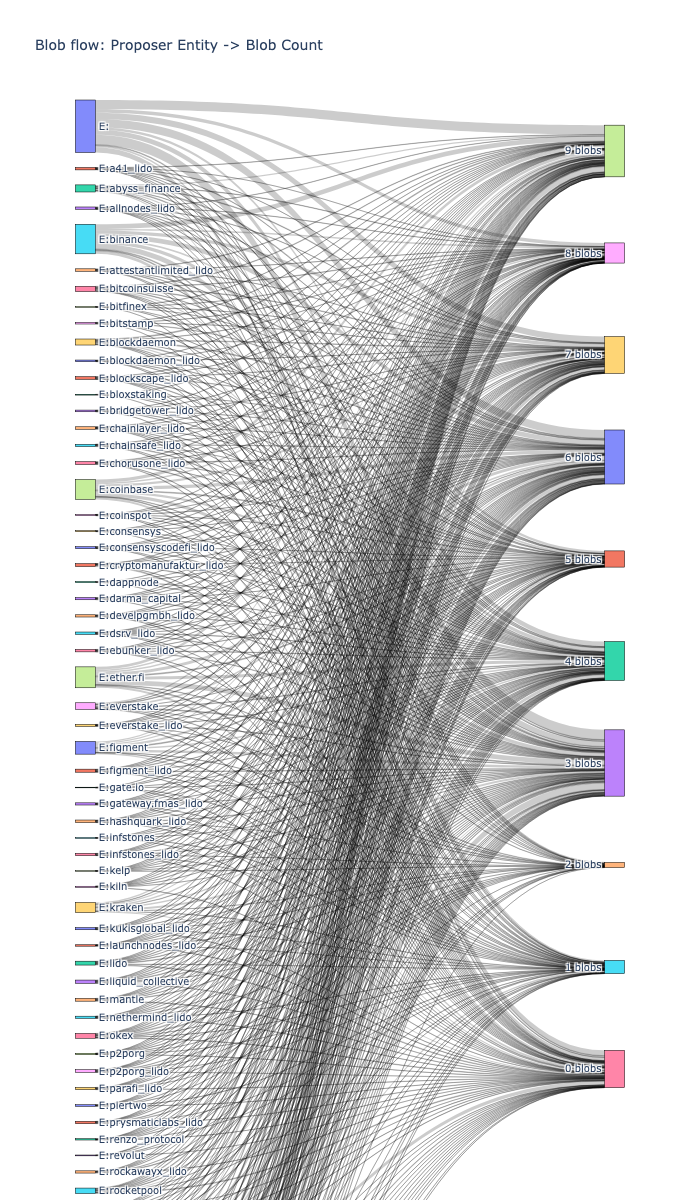

In [3]:
# Calculate block counts per entity
entity_block_counts = df_proposer_blobs.groupby("proposer_entity").size()

# Get entities that meet the threshold
valid_entities = entity_block_counts[entity_block_counts >= MIN_BLOCKS].index

# Filter the dataframe
df_filtered = df_proposer_blobs[df_proposer_blobs["proposer_entity"].isin(valid_entities)]

entity_blob_flow = (
    df_filtered.groupby(["proposer_entity", "blob_count"])
    .size()
    .reset_index(name="block_count")
)

# Create node labels: entities + blob counts (blob counts sorted descending)
entities = entity_blob_flow["proposer_entity"].unique().tolist()
blob_counts = sorted(entity_blob_flow["blob_count"].unique(), reverse=True)  # Descending

entity_nodes = [f"E:{e}" for e in entities]
blob_nodes = [f"{int(bc)} blobs" for bc in blob_counts]
all_nodes = entity_nodes + blob_nodes

# Create mapping from name to index
node_map = {name: idx for idx, name in enumerate(all_nodes)}

# Define x and y positions for nodes
n_entities = len(entity_nodes)
n_blobs = len(blob_nodes)

x_pos = []
y_pos = []

# Entity nodes on the left (x=0.01)
for i in range(n_entities):
    x_pos.append(0.01)
    y_pos.append((i + 0.5) / n_entities)

# Blob count nodes on the right (x=0.99), evenly spaced vertically (descending order)
for i in range(n_blobs):
    x_pos.append(0.99)
    y_pos.append((i + 0.5) / n_blobs)

sources = []
targets = []
values = []

for _, row in entity_blob_flow.iterrows():
    e_node = f"E:{row['proposer_entity']}"
    bc_node = f"{int(row['blob_count'])} blobs"
    if e_node in node_map and bc_node in node_map:
        sources.append(node_map[e_node])
        targets.append(node_map[bc_node])
        values.append(row["block_count"])

fig = go.Figure(
    data=[
        go.Sankey(
            arrangement="snap",
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=all_nodes,
                x=x_pos,
                y=y_pos,
            ),
            link=dict(source=sources, target=targets, value=values),
        )
    ]
)
fig.update_layout(
    title="Blob flow: Proposer Entity -> Blob Count",
    font_size=10,
    height=1200,
)
show_fig(fig)

## Relay -> Blob Count

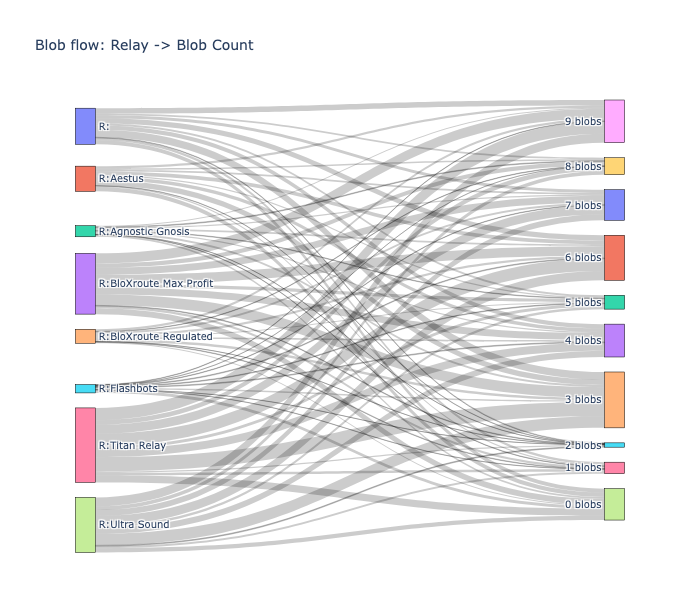

In [4]:
relay_blob_flow = (
    df_proposer_blobs.groupby(["winning_relay", "blob_count"])
    .size()
    .reset_index(name="block_count")
)

# Create node labels: relays + blob counts (blob counts sorted descending)
relays = relay_blob_flow["winning_relay"].unique().tolist()
blob_counts = sorted(relay_blob_flow["blob_count"].unique(), reverse=True)  # Descending

relay_nodes = [f"R:{r}" for r in relays]
blob_nodes = [f"{int(bc)} blobs" for bc in blob_counts]
all_nodes = relay_nodes + blob_nodes

# Create mapping from name to index
node_map = {name: idx for idx, name in enumerate(all_nodes)}

# Define x and y positions for nodes
n_relays = len(relay_nodes)
n_blobs = len(blob_nodes)

x_pos = []
y_pos = []

# Relay nodes on the left (x=0.01)
for i in range(n_relays):
    x_pos.append(0.01)
    y_pos.append((i + 0.5) / n_relays)

# Blob count nodes on the right (x=0.99), evenly spaced vertically (descending order)
for i in range(n_blobs):
    x_pos.append(0.99)
    y_pos.append((i + 0.5) / n_blobs)

sources = []
targets = []
values = []

for _, row in relay_blob_flow.iterrows():
    r_node = f"R:{row['winning_relay']}"
    bc_node = f"{int(row['blob_count'])} blobs"
    if r_node in node_map and bc_node in node_map:
        sources.append(node_map[r_node])
        targets.append(node_map[bc_node])
        values.append(row["block_count"])

fig = go.Figure(
    data=[
        go.Sankey(
            arrangement="snap",
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=all_nodes,
                x=x_pos,
                y=y_pos,
            ),
            link=dict(source=sources, target=targets, value=values),
        )
    ]
)
fig.update_layout(
    title="Blob flow: Relay -> Blob Count",
    font_size=10,
    height=600,
)
show_fig(fig)

## Proposer Entity -> Relay

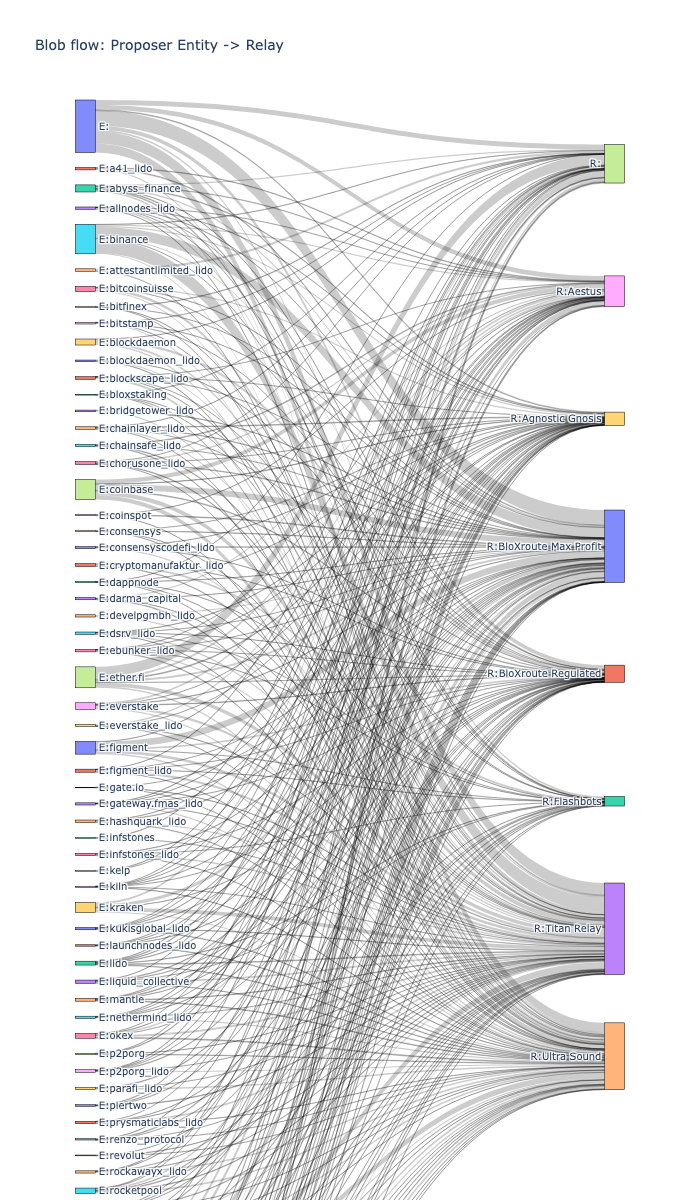

In [5]:
# Calculate block counts per entity
entity_block_counts = df_proposer_blobs.groupby("proposer_entity").size()
valid_entities = entity_block_counts[entity_block_counts >= MIN_BLOCKS].index

# Filter the dataframe
df_filtered = df_proposer_blobs[df_proposer_blobs["proposer_entity"].isin(valid_entities)]

proposer_relay_flow = (
    df_filtered.groupby(["proposer_entity", "winning_relay"])
    .size()
    .reset_index(name="block_count")
)

# Create node labels: entities + relays
entities = proposer_relay_flow["proposer_entity"].unique().tolist()
relays = proposer_relay_flow["winning_relay"].unique().tolist()

entity_nodes = [f"E:{e}" for e in entities]
relay_nodes = [f"R:{r}" for r in relays]
all_nodes = entity_nodes + relay_nodes

# Create mapping from name to index
node_map = {name: idx for idx, name in enumerate(all_nodes)}

# Define x and y positions for nodes
n_entities = len(entity_nodes)
n_relays = len(relay_nodes)

x_pos = []
y_pos = []

# Entity nodes on the left (x=0.01)
for i in range(n_entities):
    x_pos.append(0.01)
    y_pos.append((i + 0.5) / n_entities)

# Relay nodes on the right (x=0.99)
for i in range(n_relays):
    x_pos.append(0.99)
    y_pos.append((i + 0.5) / n_relays)

sources = []
targets = []
values = []

for _, row in proposer_relay_flow.iterrows():
    e_node = f"E:{row['proposer_entity']}"
    r_node = f"R:{row['winning_relay']}"
    if e_node in node_map and r_node in node_map:
        sources.append(node_map[e_node])
        targets.append(node_map[r_node])
        values.append(row["block_count"])

fig = go.Figure(
    data=[
        go.Sankey(
            arrangement="snap",
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=all_nodes,
                x=x_pos,
                y=y_pos,
            ),
            link=dict(source=sources, target=targets, value=values),
        )
    ]
)
fig.update_layout(
    title="Blob flow: Proposer Entity -> Relay",
    font_size=10,
    height=1200,
)
show_fig(fig)

## Proposer Entity -> Relay -> Blob Count

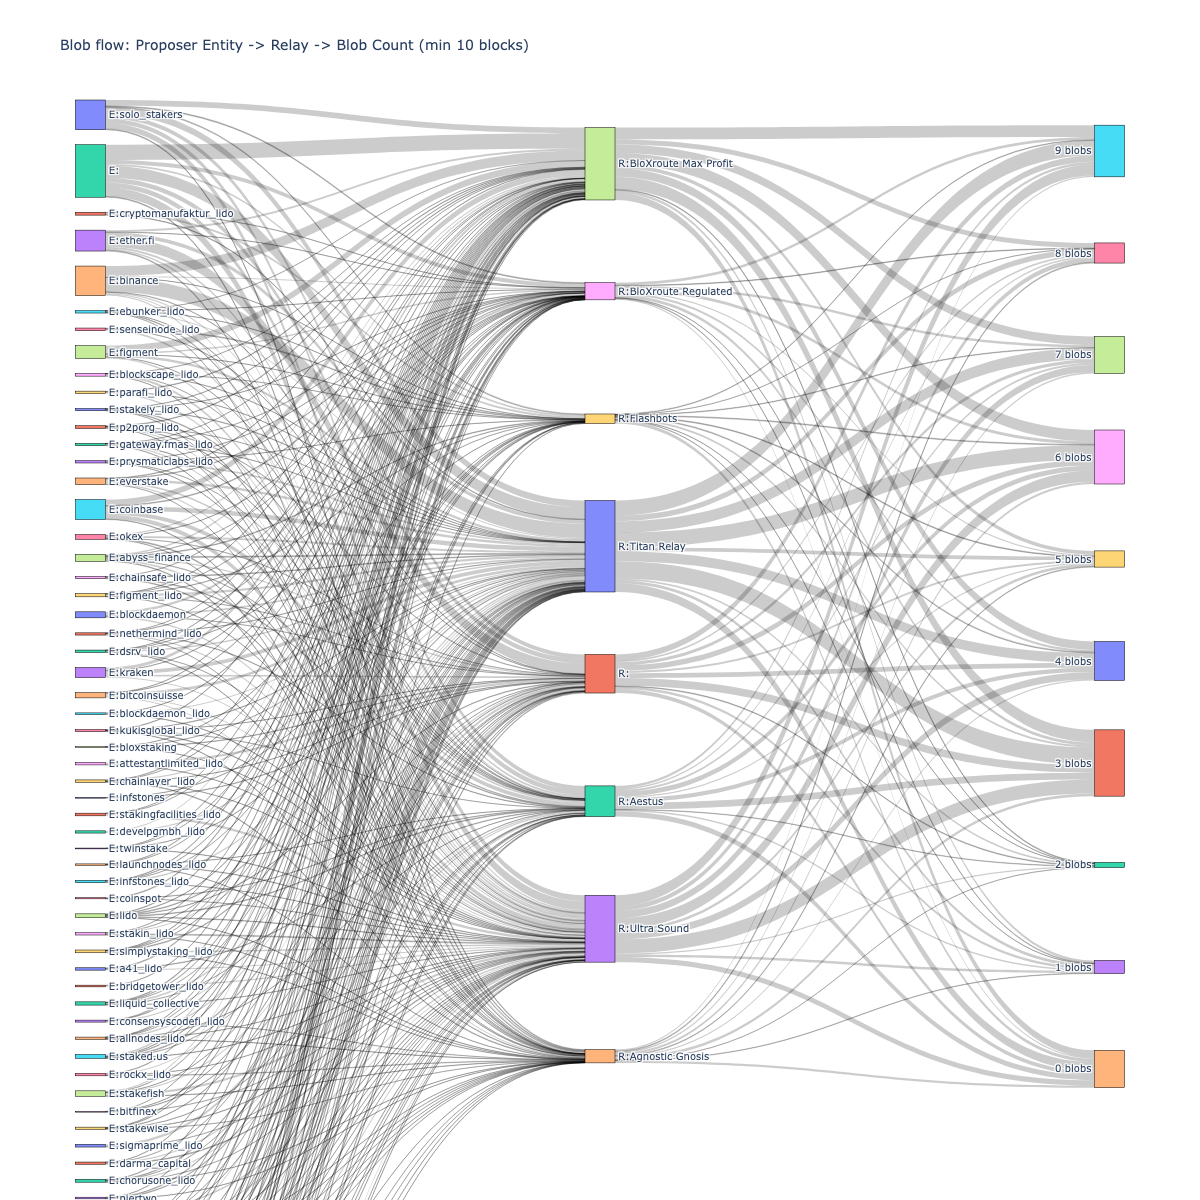

In [6]:
# Calculate block counts per entity
entity_block_counts = df_proposer_blobs.groupby("proposer_entity").size()
valid_entities = entity_block_counts[entity_block_counts >= MIN_BLOCKS].index

# Filter the dataframe
df_filtered = df_proposer_blobs[df_proposer_blobs["proposer_entity"].isin(valid_entities)]

# Aggregate flows: entity -> relay
entity_relay_flow = (
    df_filtered.groupby(["proposer_entity", "winning_relay"])
    .size()
    .reset_index(name="block_count")
)

# Aggregate flows: relay -> blob_count
relay_blob_flow = (
    df_filtered.groupby(["winning_relay", "blob_count"])
    .size()
    .reset_index(name="block_count")
)

# Create node labels: entities + relays + blob counts
entities = df_filtered["proposer_entity"].unique().tolist()
relays = df_filtered["winning_relay"].unique().tolist()
blob_counts = sorted(df_filtered["blob_count"].unique(), reverse=True)  # Descending

entity_nodes = [f"E:{e}" for e in entities]
relay_nodes = [f"R:{r}" for r in relays]
blob_nodes = [f"{int(bc)} blobs" for bc in blob_counts]
all_nodes = entity_nodes + relay_nodes + blob_nodes

# Create mapping from name to index
node_map = {name: idx for idx, name in enumerate(all_nodes)}

# Define x and y positions for nodes (3 columns)
n_entities = len(entity_nodes)
n_relays = len(relay_nodes)
n_blobs = len(blob_nodes)

x_pos = []
y_pos = []

# Entity nodes on the left (x=0.01)
for i in range(n_entities):
    x_pos.append(0.01)
    y_pos.append((i + 0.5) / n_entities)

# Relay nodes in the middle (x=0.5)
for i in range(n_relays):
    x_pos.append(0.5)
    y_pos.append((i + 0.5) / n_relays)

# Blob count nodes on the right (x=0.99)
for i in range(n_blobs):
    x_pos.append(0.99)
    y_pos.append((i + 0.5) / n_blobs)

sources = []
targets = []
values = []

# Entity -> Relay links
for _, row in entity_relay_flow.iterrows():
    e_node = f"E:{row['proposer_entity']}"
    r_node = f"R:{row['winning_relay']}"
    if e_node in node_map and r_node in node_map:
        sources.append(node_map[e_node])
        targets.append(node_map[r_node])
        values.append(row["block_count"])

# Relay -> Blob count links
for _, row in relay_blob_flow.iterrows():
    r_node = f"R:{row['winning_relay']}"
    bc_node = f"{int(row['blob_count'])} blobs"
    if r_node in node_map and bc_node in node_map:
        sources.append(node_map[r_node])
        targets.append(node_map[bc_node])
        values.append(row["block_count"])

fig = go.Figure(
    data=[
        go.Sankey(
            arrangement="snap",
            node=dict(
                pad=15,
                thickness=30,
                line=dict(color="black", width=0.5),
                label=all_nodes,
                x=x_pos,
                y=y_pos,
            ),
            link=dict(source=sources, target=targets, value=values),
        )
    ]
)
fig.update_layout(
    title=f"Blob flow: Proposer Entity -> Relay -> Blob Count (min {MIN_BLOCKS} blocks)",
    font_size=10,
    height=1200,
    width=1200,
)
show_fig(fig)